<a href="https://colab.research.google.com/github/Mahekjain2706/Semi-Asynchronous-Centralized-Learning/blob/main/Semi_Asycnchronous_Centralized_FL_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# ***Load the MNIST dataset***

In [23]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(np.int32)
X = X / 255.0

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# ***Split the dataset into training and testing sets***

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ***Split the training data among 5 clients***

In [25]:
client_data = np.array_split(X_train, 5)
client_labels = np.array_split(y_train, 5)

# ***Convert client data and labels to numpy arrays***

In [26]:
client_data = [data.to_numpy() if hasattr(data, 'to_numpy') else data for data in client_data]
client_labels = [labels.to_numpy() if hasattr(labels, 'to_numpy') else labels for labels in client_labels]

# ***Convert y_test to a numpy array if it's a pandas Series***

In [27]:
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

# ***One-hot encode the labels***

In [28]:
encoder = OneHotEncoder(sparse=False)
client_labels = [encoder.fit_transform(labels.reshape(-1, 1)) for labels in client_labels]
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

# ***Define a simple neural network***

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    return -np.mean(np.sum(labels * np.log(predictions + 1e-9), axis=1))

def accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))

class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
        self.bias2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        m = y.shape[0]
        dz2 = self.a2 - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.weights2.T) * sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.weights2 -= learning_rate * dW2
        self.bias2 -= learning_rate * db2
        self.weights1 -= learning_rate * dW1
        self.bias1 -= learning_rate * db1

# ***Initialize models for each client and the server***

In [30]:
client_models = [SimpleNN(784, 128, 10) for _ in range(5)]
server_model = SimpleNN(784, 128, 10)

# ***Training parameters***

In [31]:
epochs = 5
rounds = 10
learning_rate = 0.1

# ***Function to simulate semi-asynchronous updates***

In [32]:
def semi_async_update(client_models, server_model, client_data, client_labels, epochs, learning_rate):
    client_weights = [{'weights1': model.weights1, 'bias1': model.bias1, 'weights2': model.weights2, 'bias2': model.bias2} for model in client_models]


    client_losses = [[] for _ in range(len(client_models))]
    client_accuracies = [[] for _ in range(len(client_models))]

    for round in range(rounds):
        print(f"Round {round+1}/{rounds}")


        client_indices = np.random.permutation(len(client_models))

        for i in client_indices:
            print(f"Client {i + 1} providing information:")
            display_client_samples(client_data[i][:5], client_labels[i][:5], i)
            for epoch in range(epochs):
                outputs = client_models[i].forward(client_data[i])
                client_models[i].backward(client_data[i], client_labels[i], learning_rate)
            client_weights[i] = {'weights1': client_models[i].weights1, 'bias1': client_models[i].bias1, 'weights2': client_models[i].weights2, 'bias2': client_models[i].bias2}


        new_weights = {
            'weights1': np.mean([client_weights[i]['weights1'] for i in range(len(client_models))], axis=0),
            'bias1': np.mean([client_weights[i]['bias1'] for i in range(len(client_models))], axis=0),
            'weights2': np.mean([client_weights[i]['weights2'] for i in range(len(client_models))], axis=0),
            'bias2': np.mean([client_weights[i]['bias2'] for i in range(len(client_models))], axis=0),
        }

        server_model.weights1 = new_weights['weights1']
        server_model.bias1 = new_weights['bias1']
        server_model.weights2 = new_weights['weights2']
        server_model.bias2 = new_weights['bias2']

        for i in range(len(client_models)):
            client_models[i].weights1 = client_weights[i]['weights1']
            client_models[i].bias1 = client_weights[i]['bias1']
            client_models[i].weights2 = client_weights[i]['weights2']
            client_models[i].bias2 = client_weights[i]['bias2']

        for i, model in enumerate(client_models):
            client_predictions = model.forward(X_test)
            loss = cross_entropy_loss(client_predictions, y_test_encoded)
            acc = accuracy(client_predictions, y_test_encoded)
            client_losses[i].append(loss)
            client_accuracies[i].append(acc)
            print(f"Client {i + 1} - Loss: {loss}, Accuracy: {acc}")

    return client_losses, client_accuracies

In [33]:
def display_client_samples(samples, labels, client_index):
    plt.figure(figsize=(10, 3))
    for i in range(len(samples)):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(f'Client {client_index + 1} Samples')
    plt.show()

Round 1/10
Client 1 providing information:


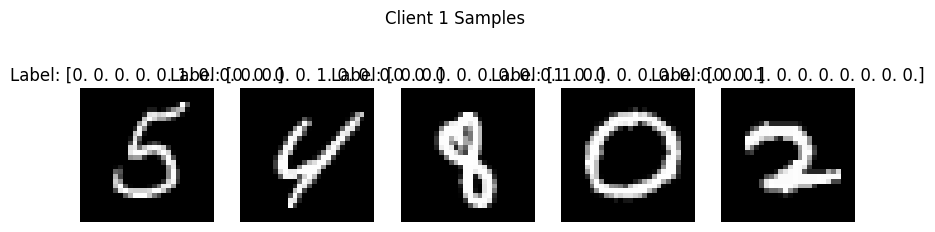

Client 2 providing information:


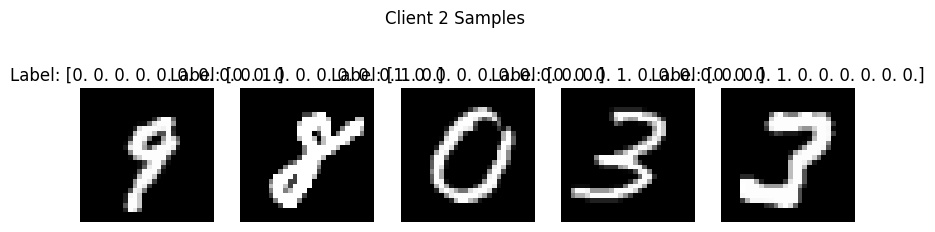

Client 5 providing information:


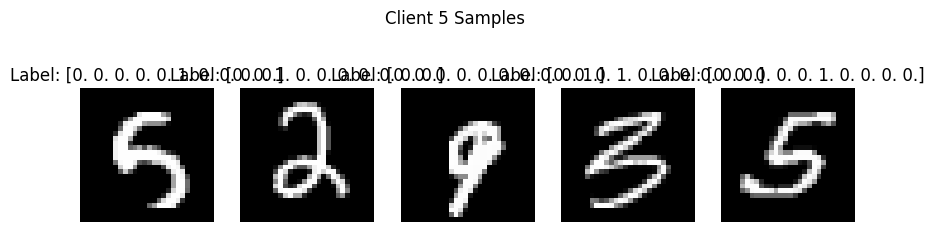

Client 3 providing information:


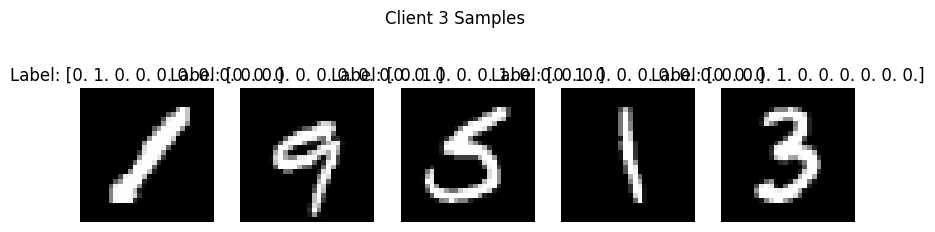

Client 4 providing information:


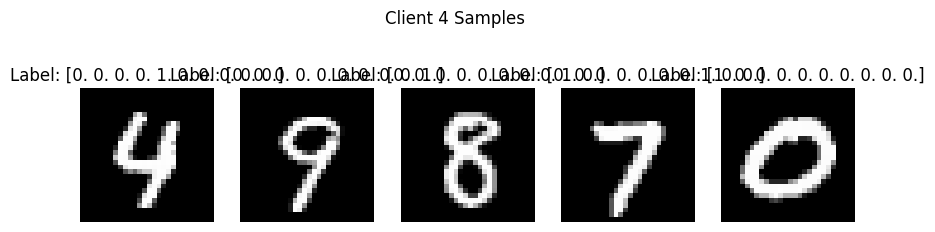

Client 1 - Loss: 2.2616500840316744, Accuracy: 0.3387142857142857
Client 2 - Loss: 2.2583502167661247, Accuracy: 0.21892857142857142
Client 3 - Loss: 2.25963502900034, Accuracy: 0.2292142857142857
Client 4 - Loss: 2.2605351567909144, Accuracy: 0.16764285714285715
Client 5 - Loss: 2.2554108081840094, Accuracy: 0.1795
Round 2/10
Client 2 providing information:


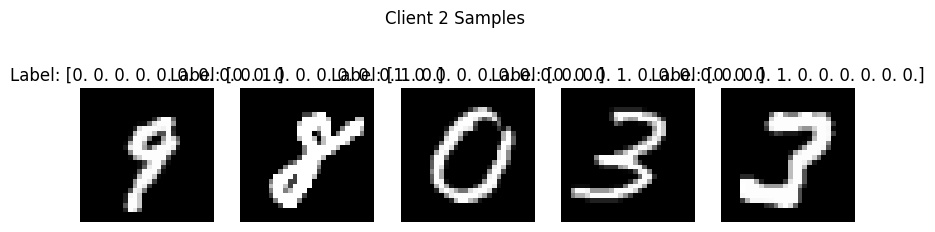

Client 4 providing information:


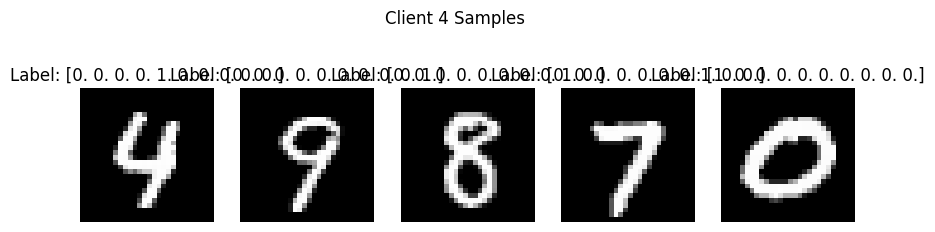

Client 5 providing information:


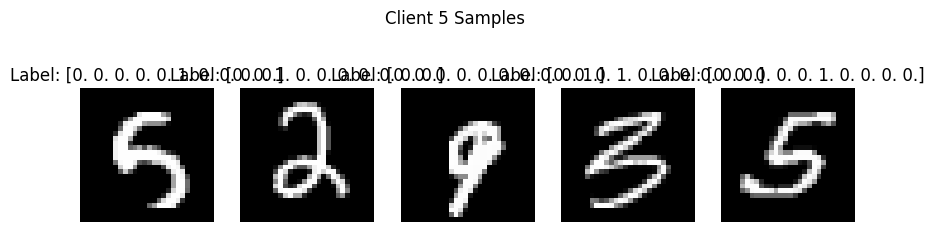

Client 3 providing information:


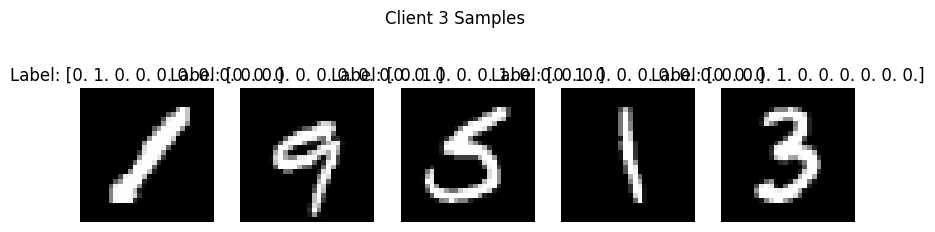

Client 1 providing information:


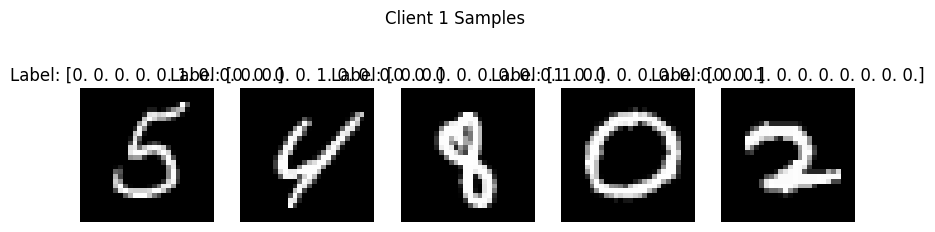

Client 1 - Loss: 2.256742834592184, Accuracy: 0.3479285714285714
Client 2 - Loss: 2.2531040676453062, Accuracy: 0.2367142857142857
Client 3 - Loss: 2.254470646922156, Accuracy: 0.2395
Client 4 - Loss: 2.255468842186896, Accuracy: 0.19228571428571428
Client 5 - Loss: 2.2497596811355796, Accuracy: 0.19285714285714287
Round 3/10
Client 2 providing information:


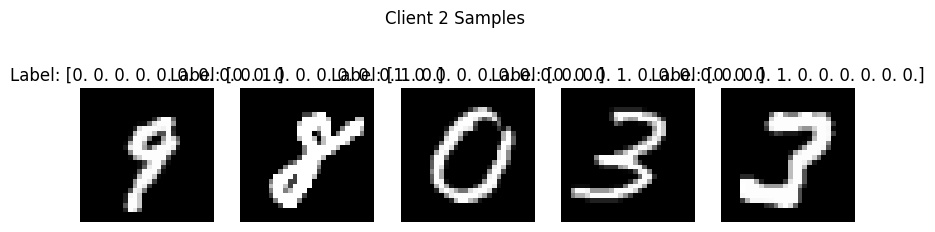

Client 3 providing information:


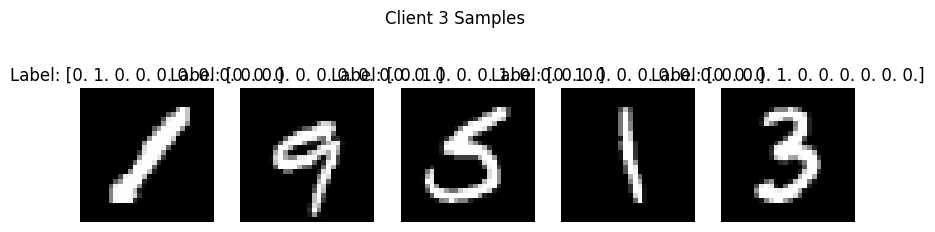

Client 4 providing information:


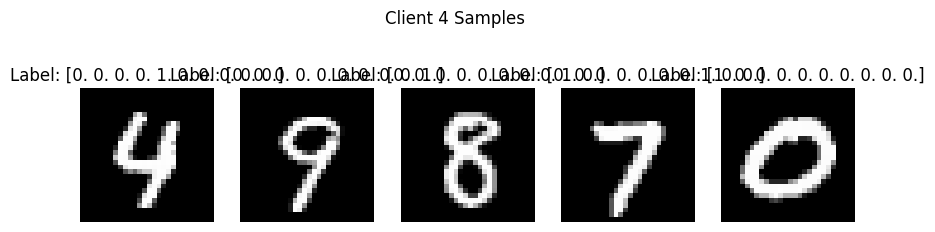

Client 5 providing information:


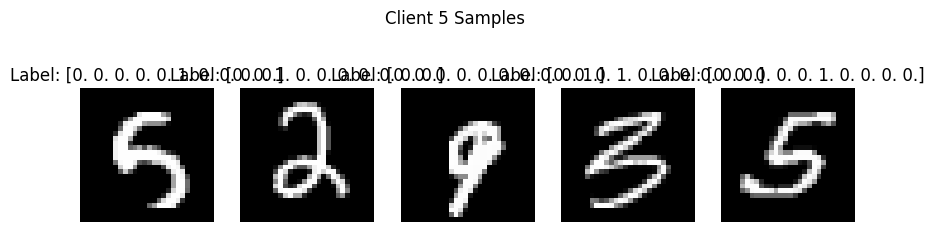

Client 1 providing information:


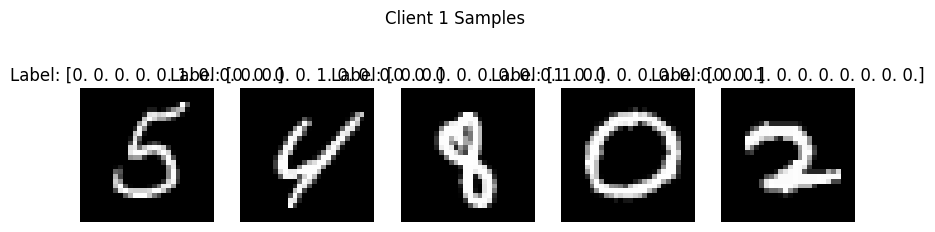

Client 1 - Loss: 2.251263782982903, Accuracy: 0.35528571428571426
Client 2 - Loss: 2.247254167572992, Accuracy: 0.2547857142857143
Client 3 - Loss: 2.2487066481715896, Accuracy: 0.24935714285714286
Client 4 - Loss: 2.2498142419377207, Accuracy: 0.22442857142857142
Client 5 - Loss: 2.2434576482780315, Accuracy: 0.20907142857142857
Round 4/10
Client 2 providing information:


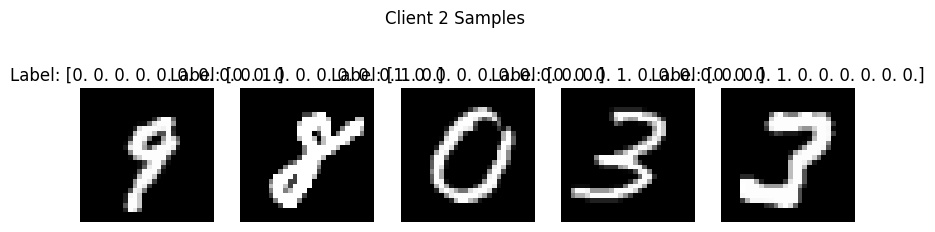

Client 1 providing information:


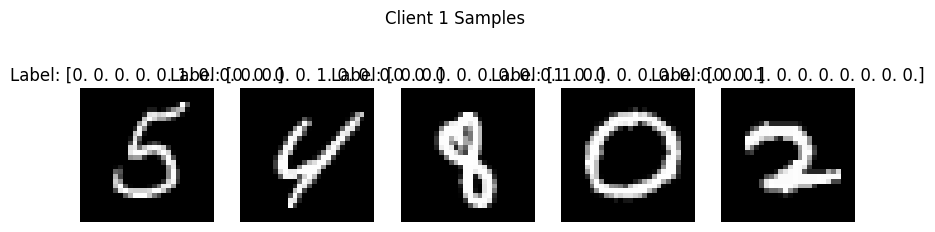

Client 4 providing information:


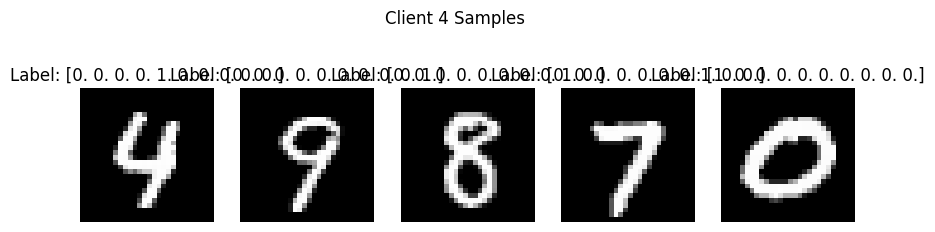

Client 3 providing information:


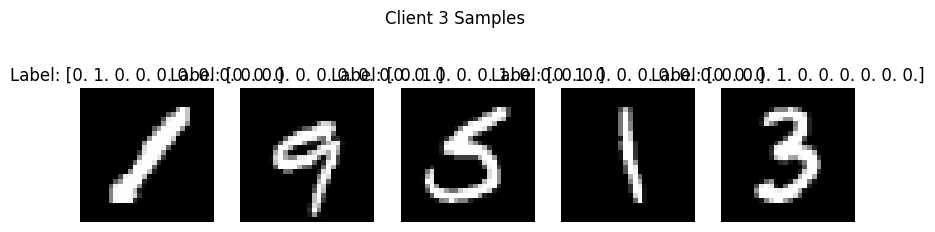

Client 5 providing information:


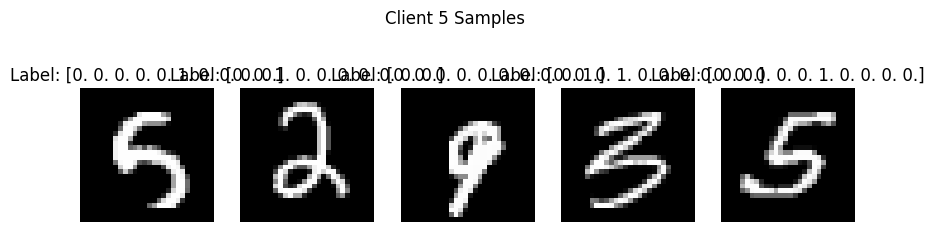

Client 1 - Loss: 2.2451528381615784, Accuracy: 0.36142857142857143
Client 2 - Loss: 2.2407398052730874, Accuracy: 0.27114285714285713
Client 3 - Loss: 2.24228201309996, Accuracy: 0.26257142857142857
Client 4 - Loss: 2.243509785767411, Accuracy: 0.2566428571428571
Client 5 - Loss: 2.2364398014234763, Accuracy: 0.22314285714285714
Round 5/10
Client 5 providing information:


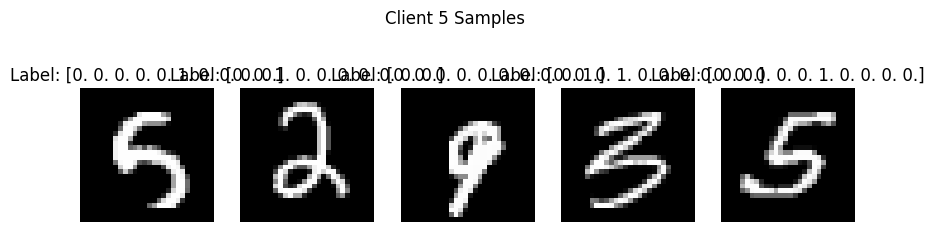

Client 3 providing information:


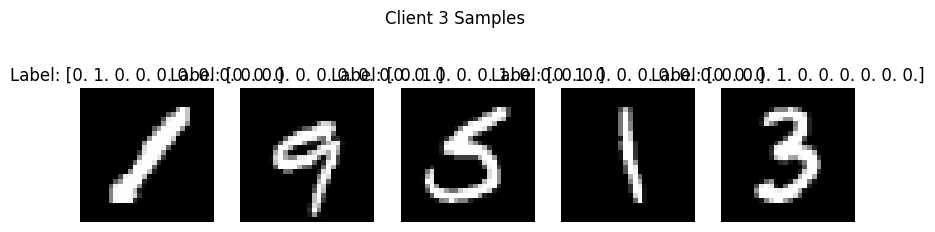

Client 2 providing information:


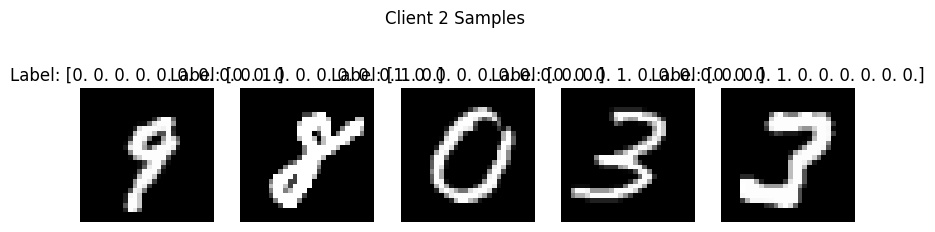

Client 4 providing information:


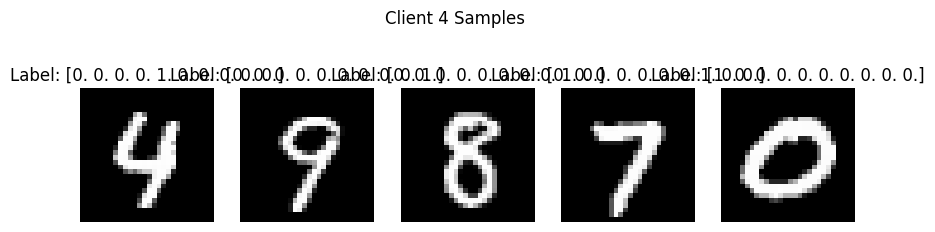

Client 1 providing information:


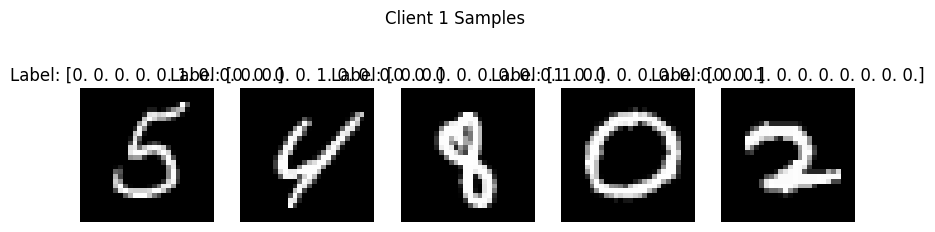

Client 1 - Loss: 2.2383465456814147, Accuracy: 0.367
Client 2 - Loss: 2.233497548588596, Accuracy: 0.2872857142857143
Client 3 - Loss: 2.235133026449616, Accuracy: 0.2754285714285714
Client 4 - Loss: 2.236490351878749, Accuracy: 0.28735714285714287
Client 5 - Loss: 2.228638601074852, Accuracy: 0.2375
Round 6/10
Client 5 providing information:


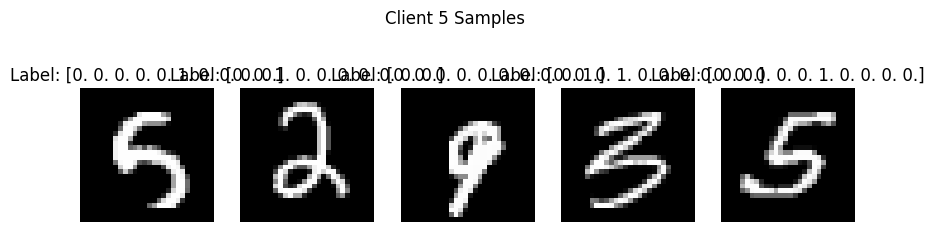

Client 2 providing information:


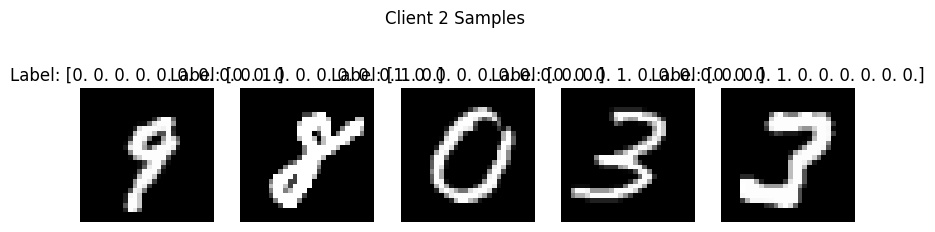

Client 4 providing information:


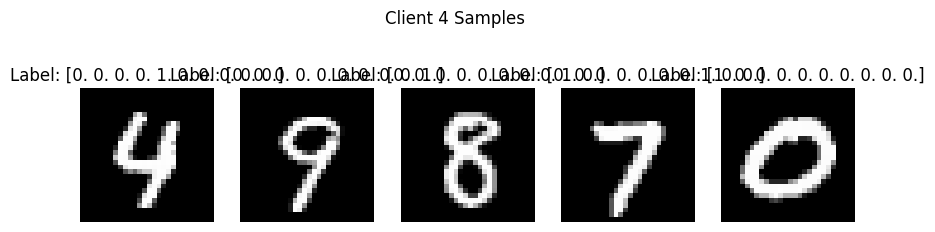

Client 1 providing information:


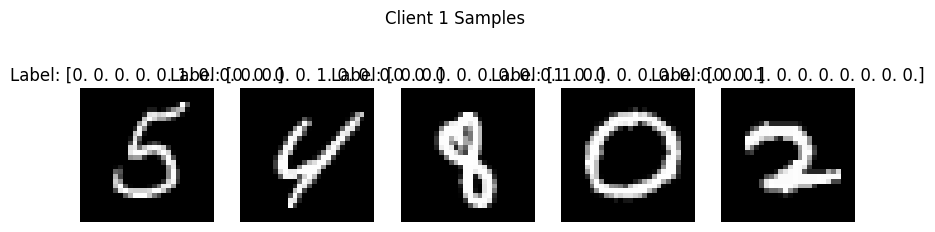

Client 3 providing information:


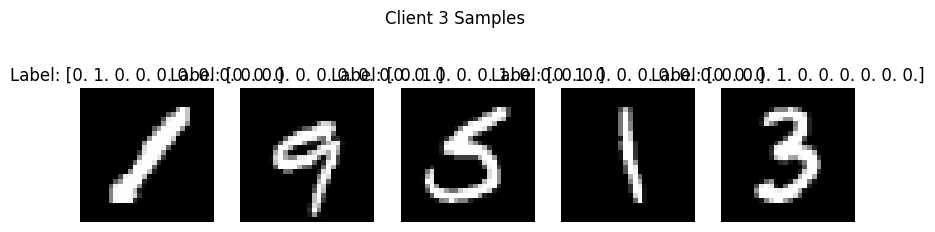

Client 1 - Loss: 2.230778650330654, Accuracy: 0.37157142857142855
Client 2 - Loss: 2.225461943842983, Accuracy: 0.3013571428571429
Client 3 - Loss: 2.2271940503868426, Accuracy: 0.2884285714285714
Client 4 - Loss: 2.228687781947448, Accuracy: 0.31307142857142856
Client 5 - Loss: 2.219984747757015, Accuracy: 0.254
Round 7/10
Client 5 providing information:


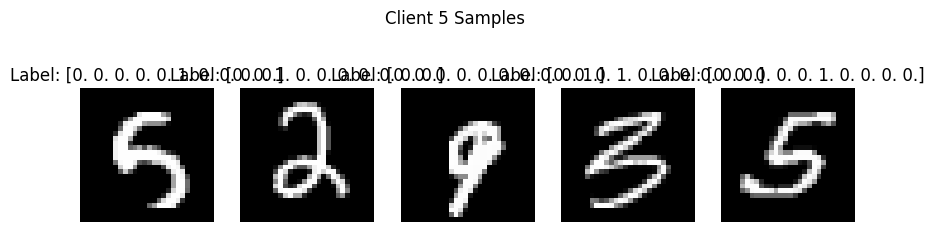

Client 2 providing information:


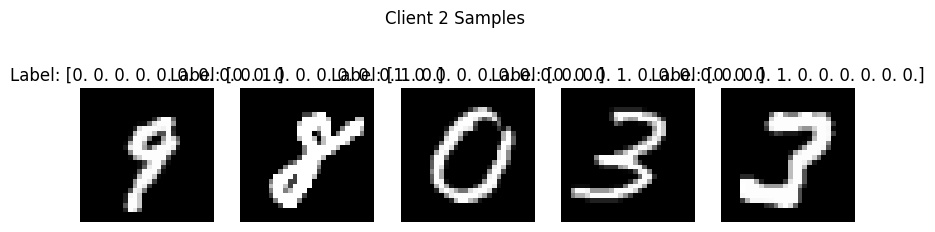

Client 3 providing information:


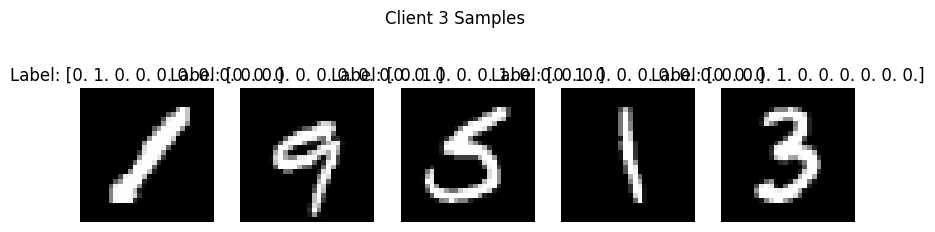

Client 1 providing information:


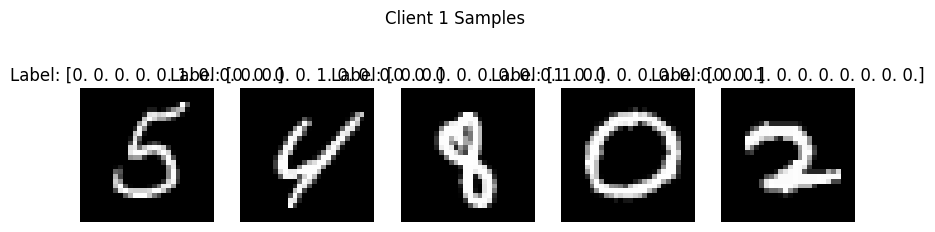

Client 4 providing information:


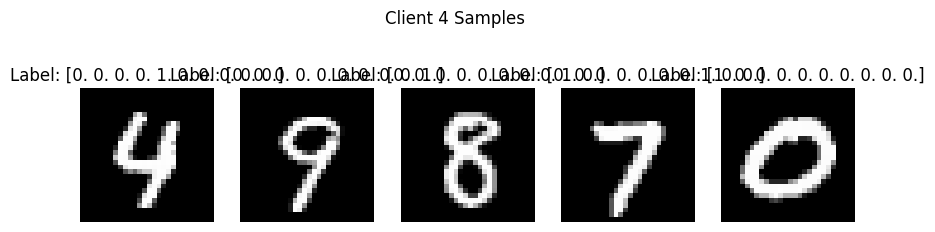

Client 1 - Loss: 2.2223808806424312, Accuracy: 0.3762857142857143
Client 2 - Loss: 2.2165664253604382, Accuracy: 0.31585714285714284
Client 3 - Loss: 2.21839853498658, Accuracy: 0.3008571428571429
Client 4 - Loss: 2.2200316138390894, Accuracy: 0.336
Client 5 - Loss: 2.210408313383587, Accuracy: 0.27214285714285713
Round 8/10
Client 1 providing information:


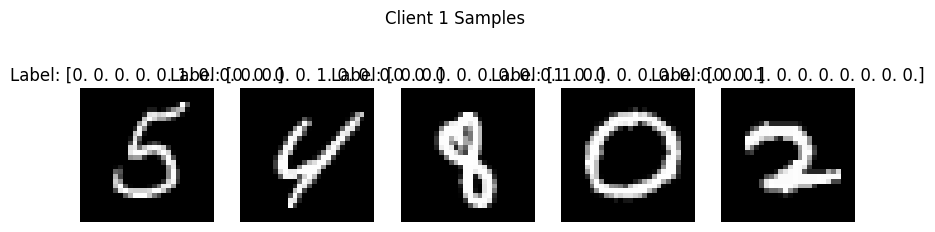

Client 3 providing information:


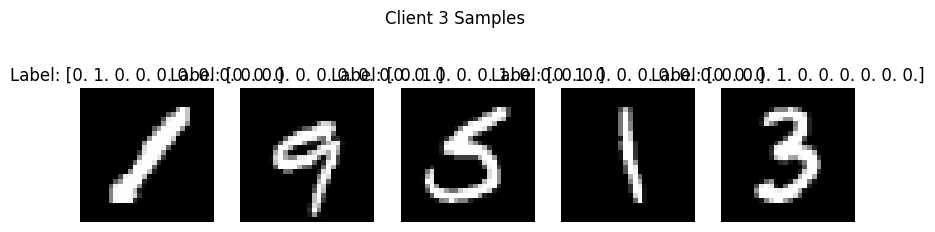

Client 4 providing information:


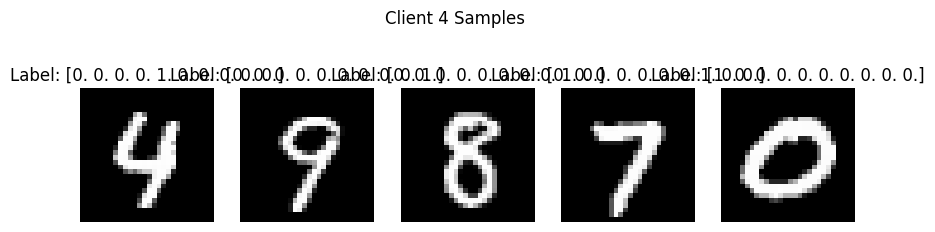

Client 5 providing information:


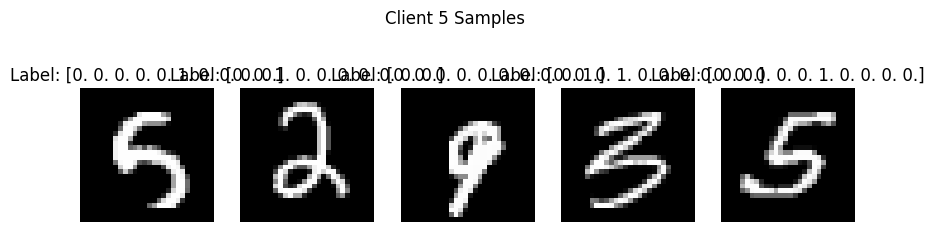

Client 2 providing information:


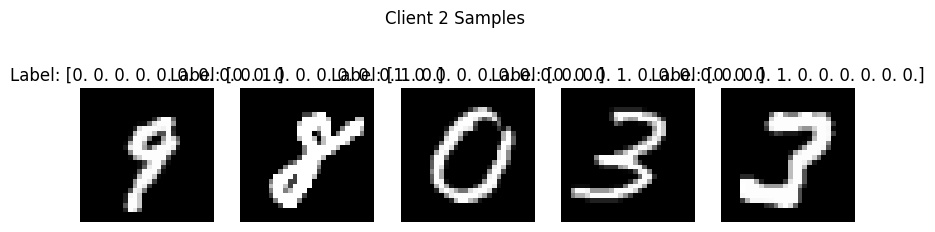

Client 1 - Loss: 2.2130839757676446, Accuracy: 0.379
Client 2 - Loss: 2.2067444418530013, Accuracy: 0.32685714285714285
Client 3 - Loss: 2.2086802732453283, Accuracy: 0.31485714285714284
Client 4 - Loss: 2.2104500599370076, Accuracy: 0.35628571428571426
Client 5 - Loss: 2.1998401431116523, Accuracy: 0.2879285714285714
Round 9/10
Client 2 providing information:


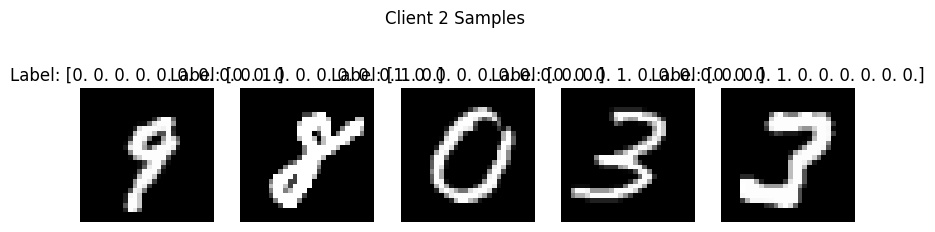

Client 4 providing information:


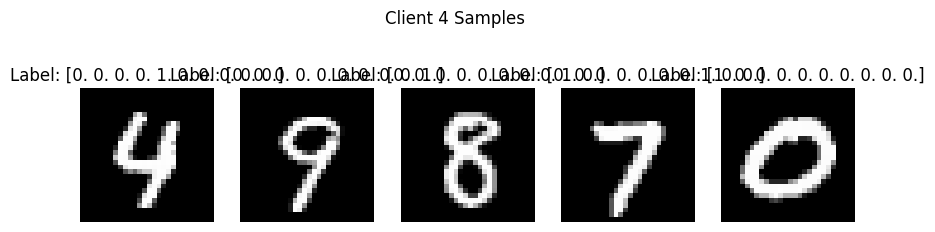

Client 5 providing information:


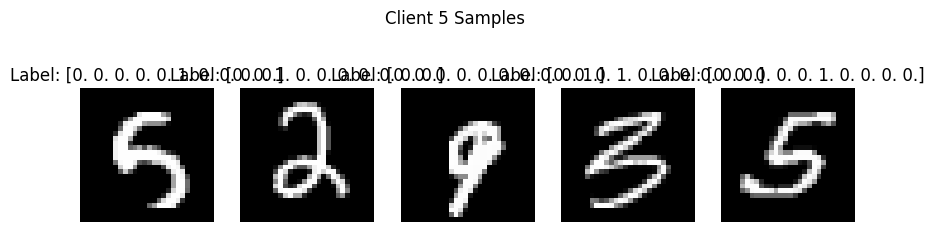

Client 1 providing information:


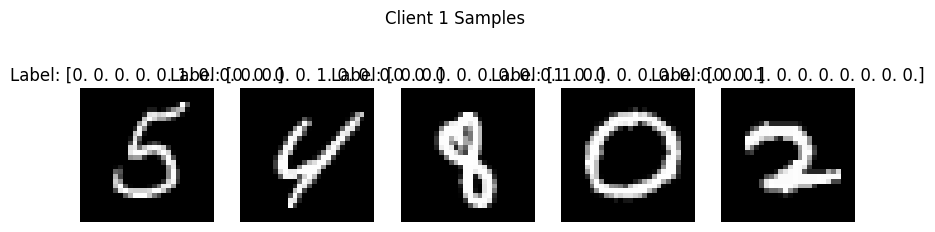

Client 3 providing information:


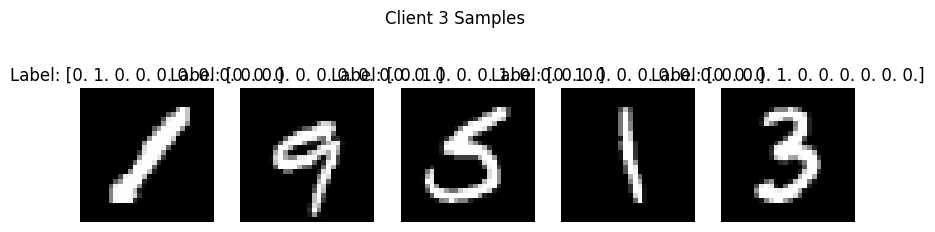

Client 1 - Loss: 2.202818965182533, Accuracy: 0.3815
Client 2 - Loss: 2.1959307949572198, Accuracy: 0.33885714285714286
Client 3 - Loss: 2.197974891714264, Accuracy: 0.32835714285714285
Client 4 - Loss: 2.1998712536542717, Accuracy: 0.37392857142857144
Client 5 - Loss: 2.188213522461909, Accuracy: 0.30885714285714283
Round 10/10
Client 3 providing information:


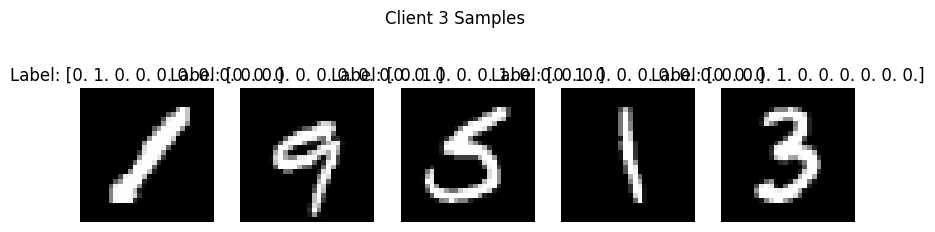

Client 1 providing information:


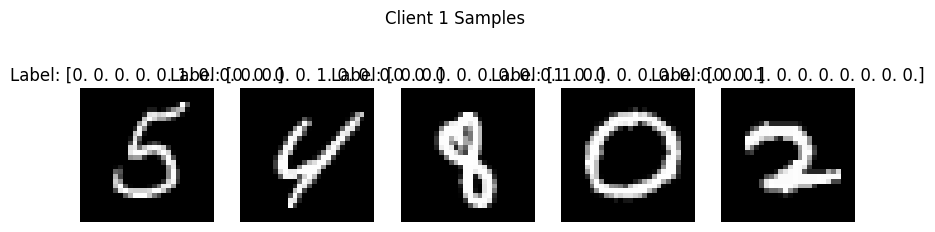

Client 2 providing information:


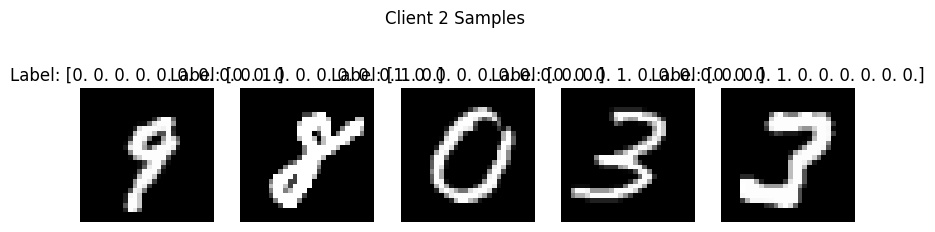

Client 4 providing information:


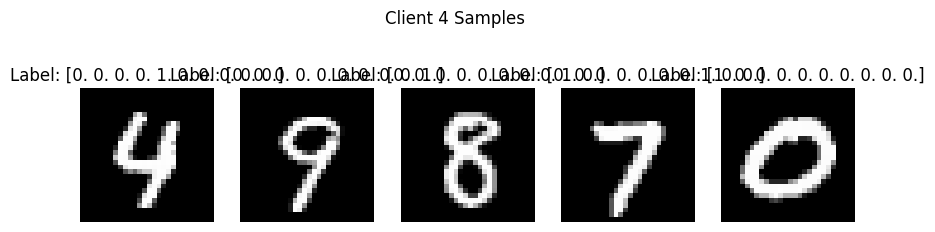

Client 5 providing information:


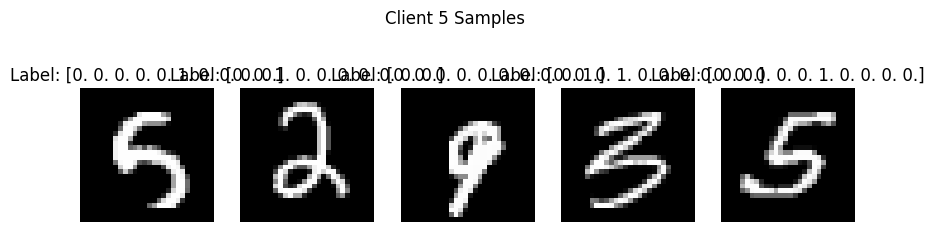

Client 1 - Loss: 2.19151869746159, Accuracy: 0.38421428571428573
Client 2 - Loss: 2.1840631713821015, Accuracy: 0.3522857142857143
Client 3 - Loss: 2.1862215474883477, Accuracy: 0.3424285714285714
Client 4 - Loss: 2.18822477780472, Accuracy: 0.3897857142857143
Client 5 - Loss: 2.175466084228768, Accuracy: 0.3276428571428571


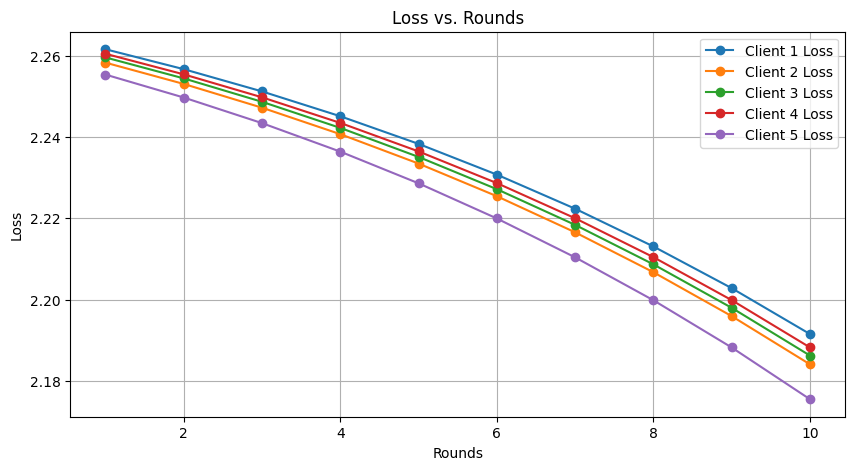

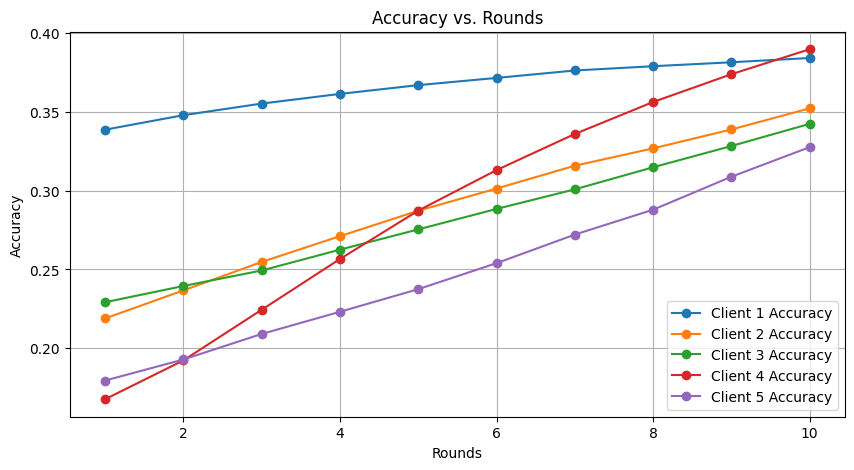

In [36]:
def plot_results(client_losses, client_accuracies):
    plt.figure(figsize=(10, 5))

    # Plot loss vs. rounds for each client
    for i in range(len(client_losses)):
        plt.plot(range(1, rounds+1), client_losses[i], marker='o', label=f'Client {i + 1} Loss')

    plt.title('Loss vs. Rounds')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))

    # Plot accuracy vs. rounds for each client
    for i in range(len(client_accuracies)):
        plt.plot(range(1, rounds+1), client_accuracies[i], marker='o', label=f'Client {i + 1} Accuracy')

    plt.title('Accuracy vs. Rounds')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulate semi-asynchronous federated learning
client_losses, client_accuracies = semi_async_update(client_models, server_model, client_data, client_labels, epochs, learning_rate)

# Plot the results
plot_results(client_losses, client_accuracies)
